# Project Name

---

## Table of Contents <a name="toc"></a>

---

- 1.[**Data Source Information**](#datasource)
- 2.[**Setup**](#setup)
  - 2.1. [Environment Details for Reproducility](#env)
  - 2.2. [Importing the Data](#dataimport)
- 3.[**Data Preprocessing**](#datapre)


## 1. Data Source Information <a name="datasource"></a>

---


## 2. Setup <a name="setup"></a>

---


In [186]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, AutoDateFormatter

from prophet import Prophet

### 2.1. Environment Information for Reproducibility: <a name="env"></a>

### 2.2. Importing the Data: <a name="dataimport"></a>

In [187]:
# Set directories
current_wdir = os.getcwd()
data_folder_hourly = current_wdir + '/Data/Hourly_Load'
data_folder_gen = current_wdir + '/Data/Gen_by_Fuel'
data_folder_weather = current_wdir + '/Data/Weather'

## 3. Data Preprocessing <a name="datapre"></a>

---

In [188]:
# Add and sort all filenames from each folder path.
file_path_load = [f'{data_folder_hourly}/{file}' for file in os.listdir(data_folder_hourly) if '.csv' in file]
file_path_load = sorted(file_path_load)

file_path_gen = [f'{data_folder_gen}/{file}' for file in os.listdir(data_folder_gen) if '.csv' in file]
file_path_gen = sorted(file_path_gen)

file_path_weather = [f'{data_folder_weather}/{file}' for file in os.listdir(data_folder_weather) if '.csv' in file]
file_path_weather = sorted(file_path_weather)

# Iterate through filenames and add them to dataframe.
# pd.read_csv can unzip as it goes with compression argument.
load_df = pd.concat([pd.read_csv(file, compression = 'gzip') for file in file_path_load], join = 'outer', ignore_index = False, axis = 0)
gen_df = pd.concat([pd.read_csv(file, compression = 'gzip') for file in file_path_gen], join = 'outer', ignore_index = False, axis = 0)
weather_df_list = []
for filename in file_path_weather:
    # delimiter has whitespace after comma, specified here as \s+.
    temp_df = pd.read_csv(filename, compression = 'gzip', delimiter = ',\s+', engine = 'python')
    temp_df['zone']= os.path.basename(filename).replace('.csv.gz', '')
    weather_df_list.append(temp_df)
weather_df = pd.concat(weather_df_list, join = 'outer', ignore_index = False, axis = 0)

In [189]:
display(load_df)
display(load_df.dtypes)

,datetime_beginning_utc,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,is_verified
0,1/1/1993 5:00:00 AM,1/1/1993 12:00:00 AM,PJM RTO,PJM,BC,BC,2358.000,True
1,1/1/1993 5:00:00 AM,1/1/1993 12:00:00 AM,PJM RTO,PJM,CNCT,AE,855.000,True
2,1/1/1993 5:00:00 AM,1/1/1993 12:00:00 AM,PJM RTO,PJM,CNCT,DPL,1150.000,True
3,1/1/1993 5:00:00 AM,1/1/1993 12:00:00 AM,PJM RTO,PJM,GPU,JC,1632.000,True
4,1/1/1993 5:00:00 AM,1/1/1993 12:00:00 AM,PJM RTO,PJM,GPU,ME,929.000,True
...,...,...,...,...,...,...,...,...
62605,3/28/2024 3:00:00 AM,3/27/2024 11:00:00 PM,RFC,MIDATL,RECO,RECO,131.877,False
62606,3/28/2024 3:00:00 AM,3/27/2024 11:00:00 PM,RFC,MIDATL,PEP,SMECO,355.931,False
62607,3/28/2024 3:00:00 AM,3/27/2024 11:00:00 PM,RFC,MIDATL,PL,UGI,101.478,True
62608,3/28/2024 3:00:00 AM,3/27/2024 11:00:00 PM,RFC,MIDATL,AE,VMEU,70.051,False


datetime_beginning_utc     object
datetime_beginning_ept     object
nerc_region                object
mkt_region                 object
zone                       object
load_area                  object
mw                        float64
is_verified                  bool
dtype: object

In [190]:
display(gen_df)
display(gen_df.dtypes)

,datetime_beginning_utc,datetime_beginning_ept,fuel_type,mw,fuel_percentage_of_total,is_renewable
0,1/1/2017 4:00:00 AM,12/31/2016 11:00:00 PM,Coal,34820,0.41,False
1,1/1/2017 4:00:00 AM,12/31/2016 11:00:00 PM,Gas,11169,0.13,False
2,1/1/2017 4:00:00 AM,12/31/2016 11:00:00 PM,Hydro,699,0.01,True
3,1/1/2017 4:00:00 AM,12/31/2016 11:00:00 PM,Multiple Fuels,266,0.00,False
4,1/1/2017 4:00:00 AM,12/31/2016 11:00:00 PM,Nuclear,34269,0.41,False
...,...,...,...,...,...,...
21095,1/1/2024 5:00:00 AM,1/1/2024 12:00:00 AM,Oil,221,0.00,False
21096,1/1/2024 5:00:00 AM,1/1/2024 12:00:00 AM,Other Renewables,690,0.01,True
21097,1/1/2024 5:00:00 AM,1/1/2024 12:00:00 AM,Solar,12,0.00,True
21098,1/1/2024 5:00:00 AM,1/1/2024 12:00:00 AM,Storage,0,0.00,False


datetime_beginning_utc       object
datetime_beginning_ept       object
fuel_type                    object
mw                            int64
fuel_percentage_of_total    float64
is_renewable                   bool
dtype: object

In [191]:
display(weather_df)
display(weather_df.dtypes)

,Date,MaxTemperature,MinTemperature,AvgTemperature,Precipitation,zone
0,2015-01-01,43,17,30.0,0.00,AE
1,2015-01-02,45,24,34.5,0.00,AE
2,2015-01-03,47,21,34.0,0.62,AE
3,2015-01-04,64,46,55.0,0.26,AE
4,2015-01-05,50,25,37.5,0.00,AE
...,...,...,...,...,...,...
11417,2024-04-05,57,40,48.5,0.00,PEP
11418,2024-04-06,57,41,49.0,0.00,PEP
11419,2024-04-07,65,43,54.0,0.00,PEP
11420,2024-04-08,71,44,57.5,0.00,PEP


Date              object
MaxTemperature    object
MinTemperature    object
AvgTemperature    object
Precipitation     object
zone              object
dtype: object

In [192]:
# Convert to datetime. The two dataframes share column names.
date_cols = ['datetime_beginning_utc', 'datetime_beginning_ept']
load_df[date_cols] = load_df[date_cols].apply(pd.to_datetime, format = '%m/%d/%Y %I:%M:%S %p', utc = False)
gen_df[date_cols] = gen_df[date_cols].apply(pd.to_datetime, format = '%m/%d/%Y %I:%M:%S %p', utc = False)
weather_df['Date'] = weather_df['Date'].apply(pd.to_datetime, format = '%Y-%m-%d', utc = False)

In [193]:
sorted(load_df['zone'].unique())

['AE',
 'AEP',
 'AP',
 'ATSI',
 'BC',
 'CE',
 'CNCT',
 'DAY',
 'DEOK',
 'DOM',
 'DPL',
 'DUQ',
 'EKPC',
 'GPU',
 'JC',
 'ME',
 'OVEC',
 'PE',
 'PEP',
 'PL',
 'PN',
 'PS',
 'RECO',
 'RTO']

Zones

`AE` - New Jersey
`AEP` - Ohio
`AP` - West Virginia
`ATSI` - Ohio
`BC` - Maryland
`CE` - Northern Illinois
`CNCT` - Connecticut
`DAY` - Ohio
`DEOK` - Ohio
`DOM` - Virginia
`DPL` - Connecticut
`DUQ` - Pennsylvania
`EKPC` - Kentucky
`GPU` - New Jersey
`JC` - New Jersey
`ME` - Pennsylvania
`OVEC` - Ohio
`PE` - Pennsylvania
`PEP` - Maryland
`PL` - Pennsylvania
`PN` - Pennsylvania
`PS` - New Jersey
`RECO` - New Jersey

`RTO` - Regional Transmission Organization (PJM) - Aggregated Sum

In [194]:
load_zone_df = load_df[['datetime_beginning_ept', 'zone', 'mw']].groupby(['datetime_beginning_ept', 'zone'], as_index = False).sum()

In [195]:
load_noRTO_df = load_zone_df.drop(load_zone_df[load_zone_df['zone'] == 'RTO'].index)

In [196]:
load_noRTO_df

,datetime_beginning_ept,zone,mw
0,1993-01-01 00:00:00,BC,2358.000
1,1993-01-01 00:00:00,CNCT,2005.000
2,1993-01-01 00:00:00,GPU,3772.000
3,1993-01-01 00:00:00,PE,3015.000
4,1993-01-01 00:00:00,PEP,2137.000
...,...,...,...
4043319,2024-03-27 23:00:00,PEP,2698.059
4043320,2024-03-27 23:00:00,PL,4062.639
4043321,2024-03-27 23:00:00,PN,1731.625
4043322,2024-03-27 23:00:00,PS,4245.845


In [197]:
zone_list = sorted(load_df['zone'].unique())
for i in zone_list:
    print(load_zone_df[['datetime_beginning_ept', 'zone']].loc[load_zone_df['zone'] == i].min())

datetime_beginning_ept    2015-01-01 00:00:00
zone                                       AE
dtype: object
datetime_beginning_ept    2002-01-01 00:00:00
zone                                      AEP
dtype: object
datetime_beginning_ept    2002-01-01 00:00:00
zone                                       AP
dtype: object
datetime_beginning_ept    2011-06-01 00:00:00
zone                                     ATSI
dtype: object
datetime_beginning_ept    1993-01-01 00:00:00
zone                                       BC
dtype: object
datetime_beginning_ept    2004-05-01 00:00:00
zone                                       CE
dtype: object
datetime_beginning_ept    1993-01-01 00:00:00
zone                                     CNCT
dtype: object
datetime_beginning_ept    2004-10-01 00:00:00
zone                                      DAY
dtype: object
datetime_beginning_ept    2012-01-01 00:00:00
zone                                     DEOK
dtype: object
datetime_beginning_ept    2005-05-01 00:00:00


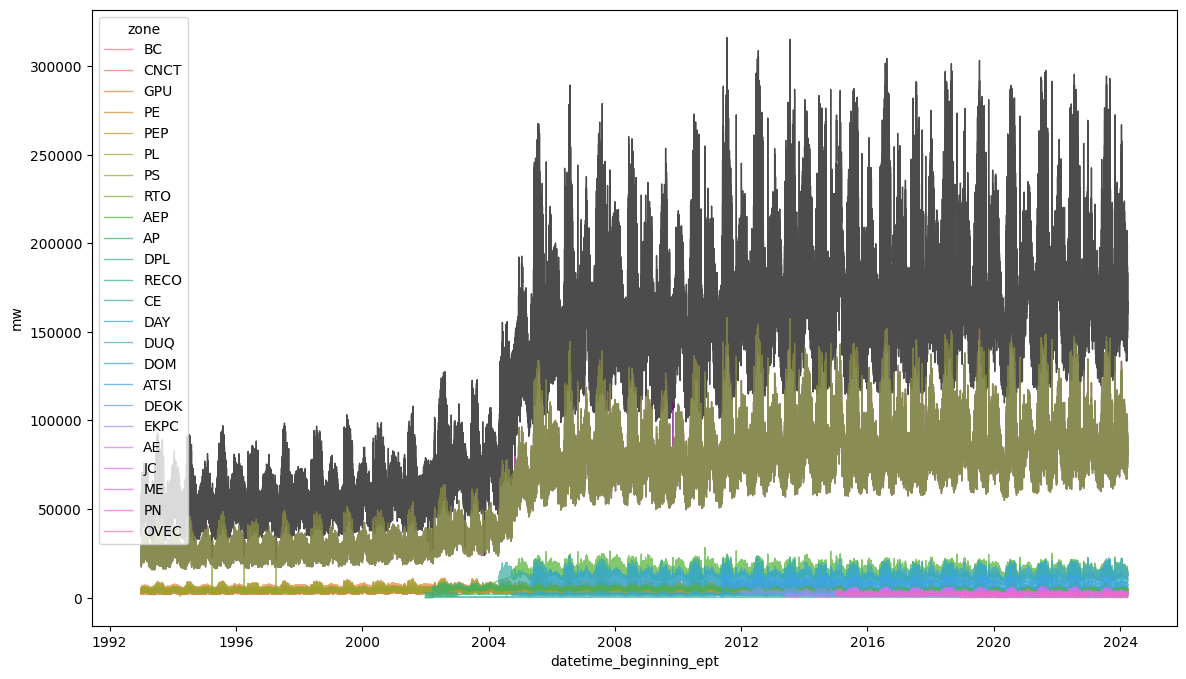

In [198]:
ax, fig = plt.subplots(figsize = (14, 8))
# Black - Sum of ALL
ax = sns.lineplot(load_zone_df[['datetime_beginning_ept', 'mw']].groupby(['datetime_beginning_ept'], as_index = False).sum(), x = 'datetime_beginning_ept', y = 'mw', alpha = 0.7, lw = 1, c = 'black')
# Purple - Sum of All but NO RTO
ax = sns.lineplot(load_noRTO_df[['datetime_beginning_ept', 'mw']].groupby(['datetime_beginning_ept'], as_index = False).sum(), x = 'datetime_beginning_ept', y = 'mw', alpha = 0.7, lw = 1, c = 'purple')
ax = sns.lineplot(load_zone_df, x = 'datetime_beginning_ept', y = 'mw',  hue = 'zone', alpha = 0.7, lw = 1)

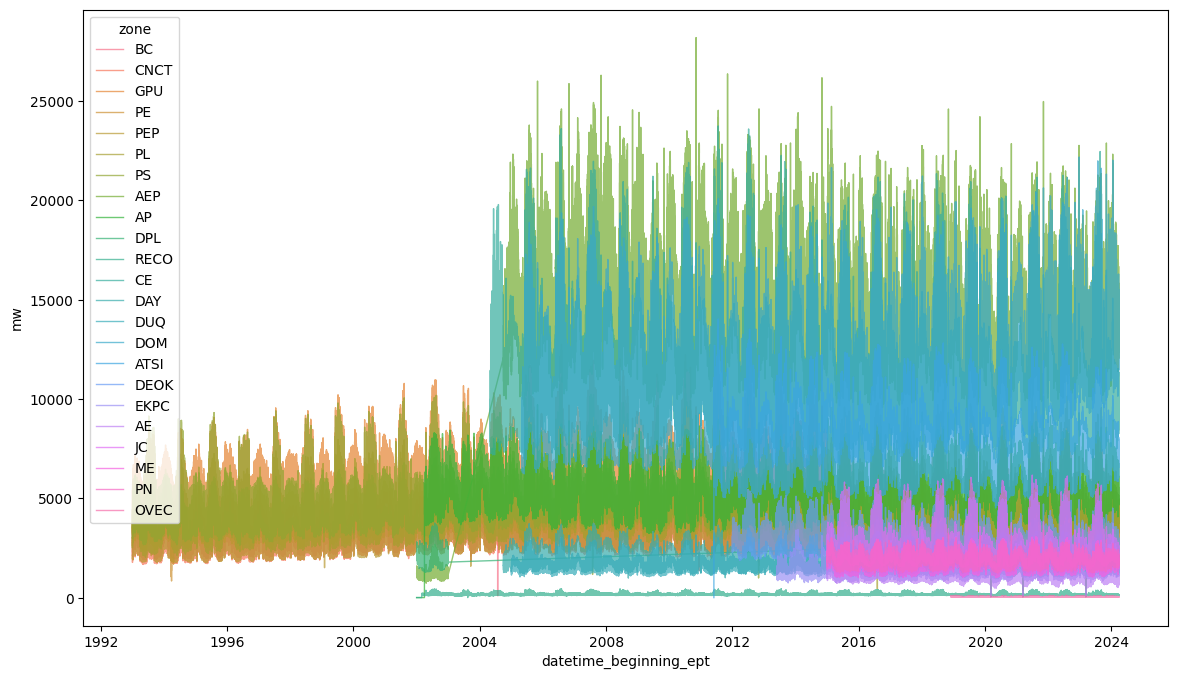

In [199]:
ax, fig = plt.subplots(figsize = (14, 8))
ax = sns.lineplot(load_noRTO_df[['datetime_beginning_ept', 'mw', 'zone']].groupby(['datetime_beginning_ept', 'zone'], as_index = False).sum(), x = 'datetime_beginning_ept', y = 'mw', hue = 'zone', alpha = 0.7, lw = 1)

In [200]:
def load_zone_plot(zone_df):
    """Finds all unique zone names and prints to output (n x 2) subplot array of line plots where x = datetime vs y = MW. 
    Can handle any length of list of strings.

    Parameters:
        zones_df (list): Pandas dataframe grouped by zone and time such as load_zone_df.
    
    Returns:
        None. Prints plot to output."""
    
    zone_list = zone_df['zone'].unique()
    color_pal = ['#005d5d', '#570408']
    
    fig, ax = plt.subplots(int(np.ceil(len(zone_list)/2)), 2, figsize = (16, 16), sharey = False, sharex = False)
    for i, zone in enumerate(zone_list):
        #print(f'{i} {zone} -- [{i//2}, {i%2}]')
        # i iterates through axes rows and columns with // and % operators 
        # ([0,0] to [0,1] to [1,0] ... etc).
        sns.lineplot(load_zone_df.loc[load_zone_df['zone'] == zone], ax = ax[i//2, i%2], 
                     x = 'datetime_beginning_ept', y = 'mw', 
                     alpha = 0.7, lw = 1, c = color_pal[int(i % 4 < 2)])
        ax[i//2, i%2].set_title(zone, y = 1)
        ax[i//2, i%2].set_xlabel(None)
        ax[i//2, i%2].set_ylabel(None)
        
    plt.subplots_adjust(wspace = 0.3, hspace = 1)
    fig.suptitle('Hourly Load of Each Zone')
    fig.supxlabel('Datetime')
    fig.supylabel('Megawatts (MW)')
    fig.tight_layout()

    # Check if odd number of plots and delete last subplot if true.
    if len(zone_list) % 2 != 0:
        fig.delaxes(ax[i // 2, (len(zone_list) % 2)])
    
    return None

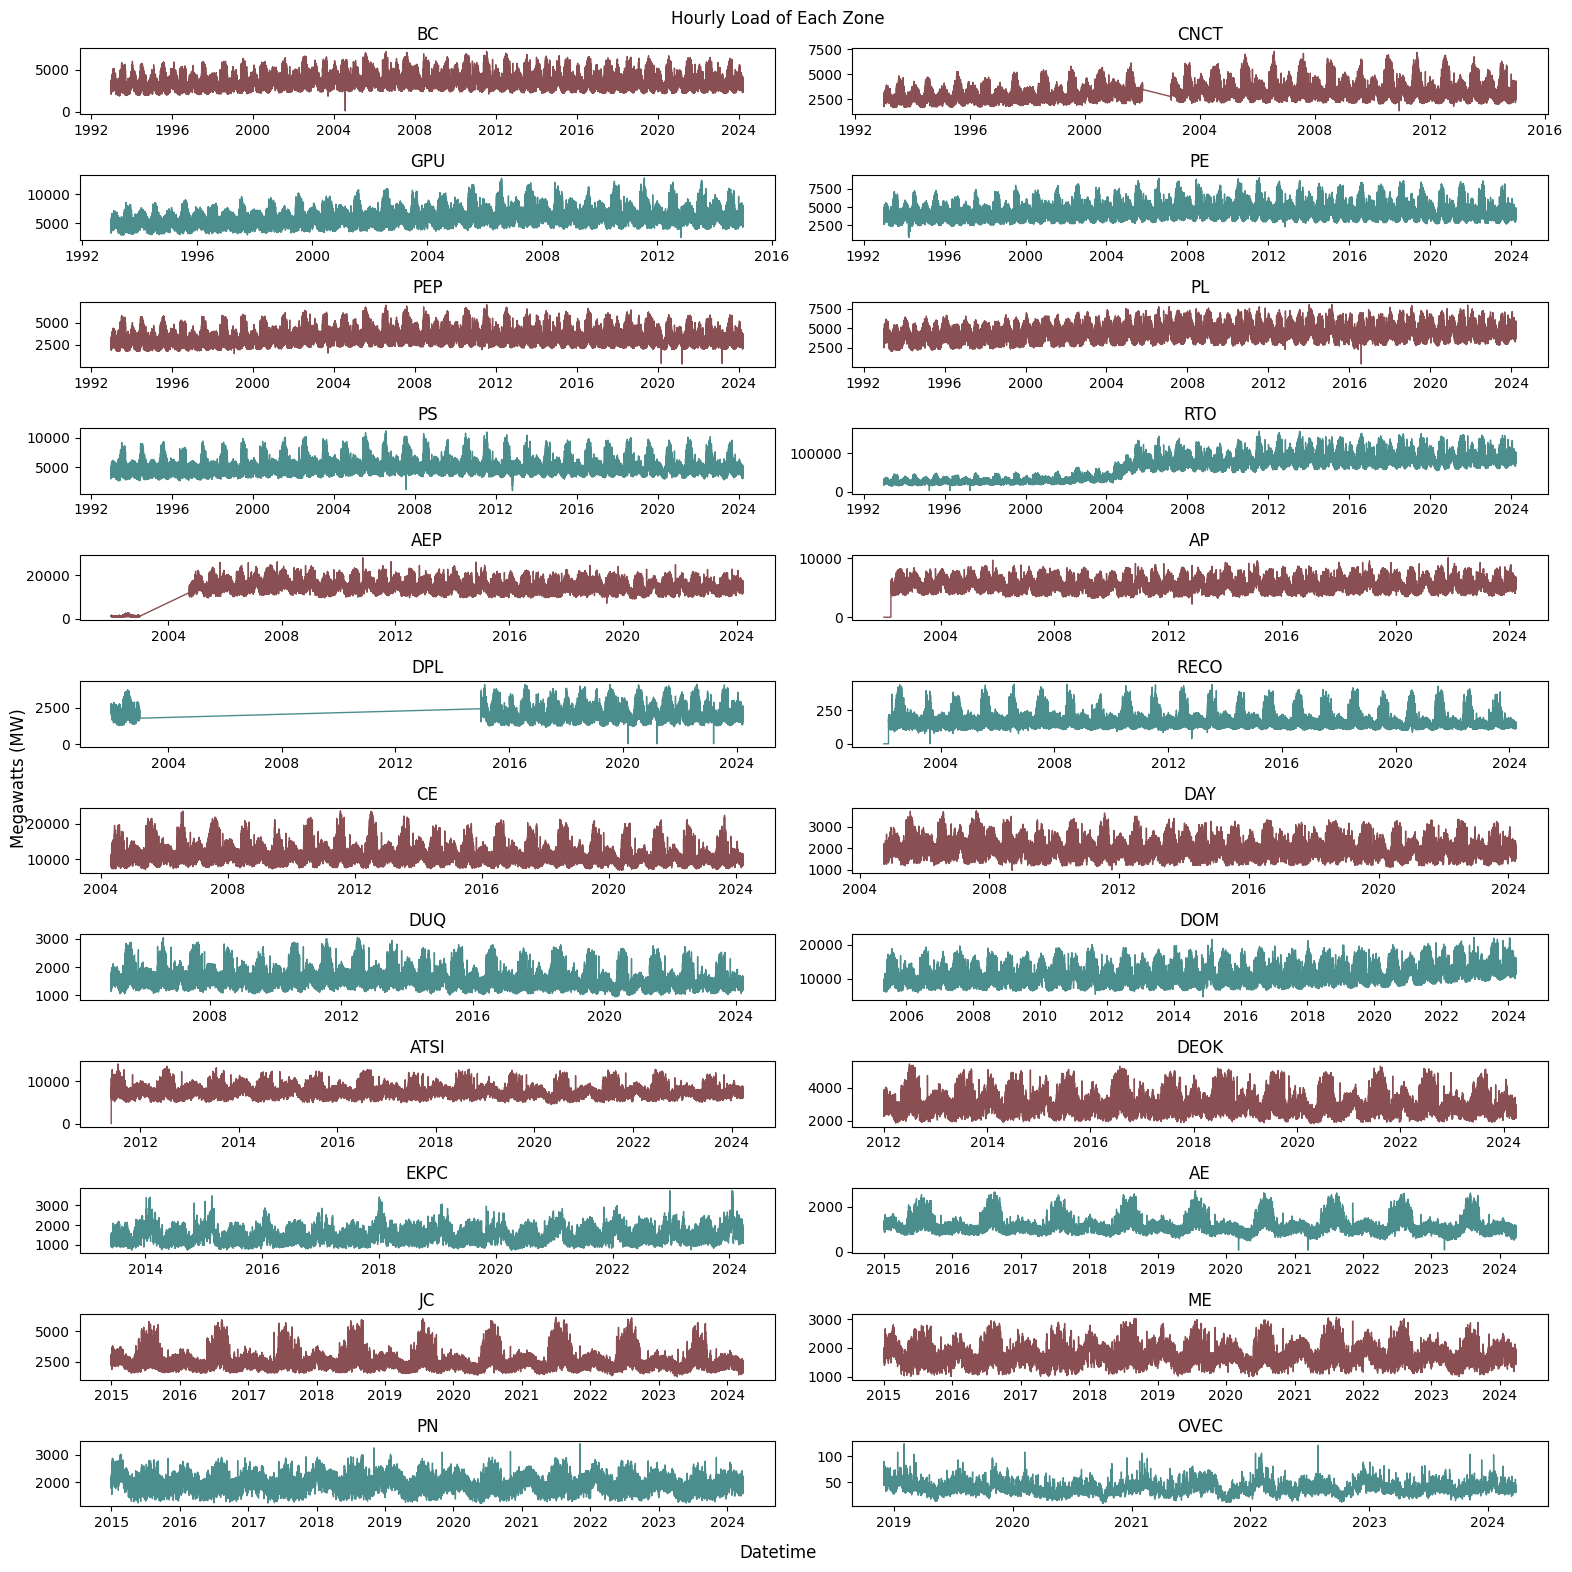

In [201]:
load_zone_plot(load_zone_df)

Atlantic City Electric Co. (AE), Choosing ComEd (CE), Dominion (DOM), Jersey Central Power & Light (JC), Potomac Electric Power Co. (PEP)

In [202]:
zones = ['AE', 'CE', 'DOM', 'JC', 'PEP']
load_zone_df = load_zone_df.loc[load_zone_df['zone'].isin(zones)]

In [215]:
print('################### Weather Data ###################')
for zone in zones:
    date_min = weather_df.loc[weather_df['zone'] == zone]['Date'].min()
    date_max = weather_df.loc[weather_df['zone'] == zone]['Date'].max()
    print(f'{zone} - {date_min} | {date_max}')
    miss_date = pd.date_range(start = date_min, end = date_max).difference(weather_df['Date'])
    print(f"{'':<5}Missing Dates: {miss_date if len(miss_date) > 0 else False}")

print('\n################### Energy Data ###################')
for zone in zones:
    date_min = load_zone_df.loc[load_zone_df['zone'] == zone]['datetime_beginning_ept'].min()
    date_max = load_zone_df.loc[load_zone_df['zone'] == zone]['datetime_beginning_ept'].max()
    print(f'{zone} - {date_min} | {date_max}')
    miss_date = pd.date_range(start = date_min, end = date_max).difference(load_zone_df['datetime_beginning_ept'])
    print(f"{'':<5}Missing Dates: {miss_date if len(miss_date) > 0 else False}")

################### Weather Data ###################
AE - 2015-01-01 00:00:00 | 2024-04-09 00:00:00
     Missing Dates: False
CE - 2004-05-01 00:00:00 | 2024-04-09 00:00:00
     Missing Dates: False
DOM - 2005-05-01 00:00:00 | 2024-04-09 00:00:00
     Missing Dates: False
JC - 2015-01-01 00:00:00 | 2024-04-10 00:00:00
     Missing Dates: False
PEP - 1993-01-01 00:00:00 | 2024-04-09 00:00:00
     Missing Dates: False

################### Energy Data ###################
AE - 2015-01-01 00:00:00 | 2024-03-27 23:00:00
     Missing Dates: False
CE - 2004-05-01 00:00:00 | 2024-03-27 23:00:00
     Missing Dates: False
DOM - 2005-05-01 00:00:00 | 2024-03-27 23:00:00
     Missing Dates: False
JC - 2015-01-01 00:00:00 | 2024-03-27 23:00:00
     Missing Dates: False
PEP - 1993-01-01 00:00:00 | 2024-03-27 23:00:00
     Missing Dates: False


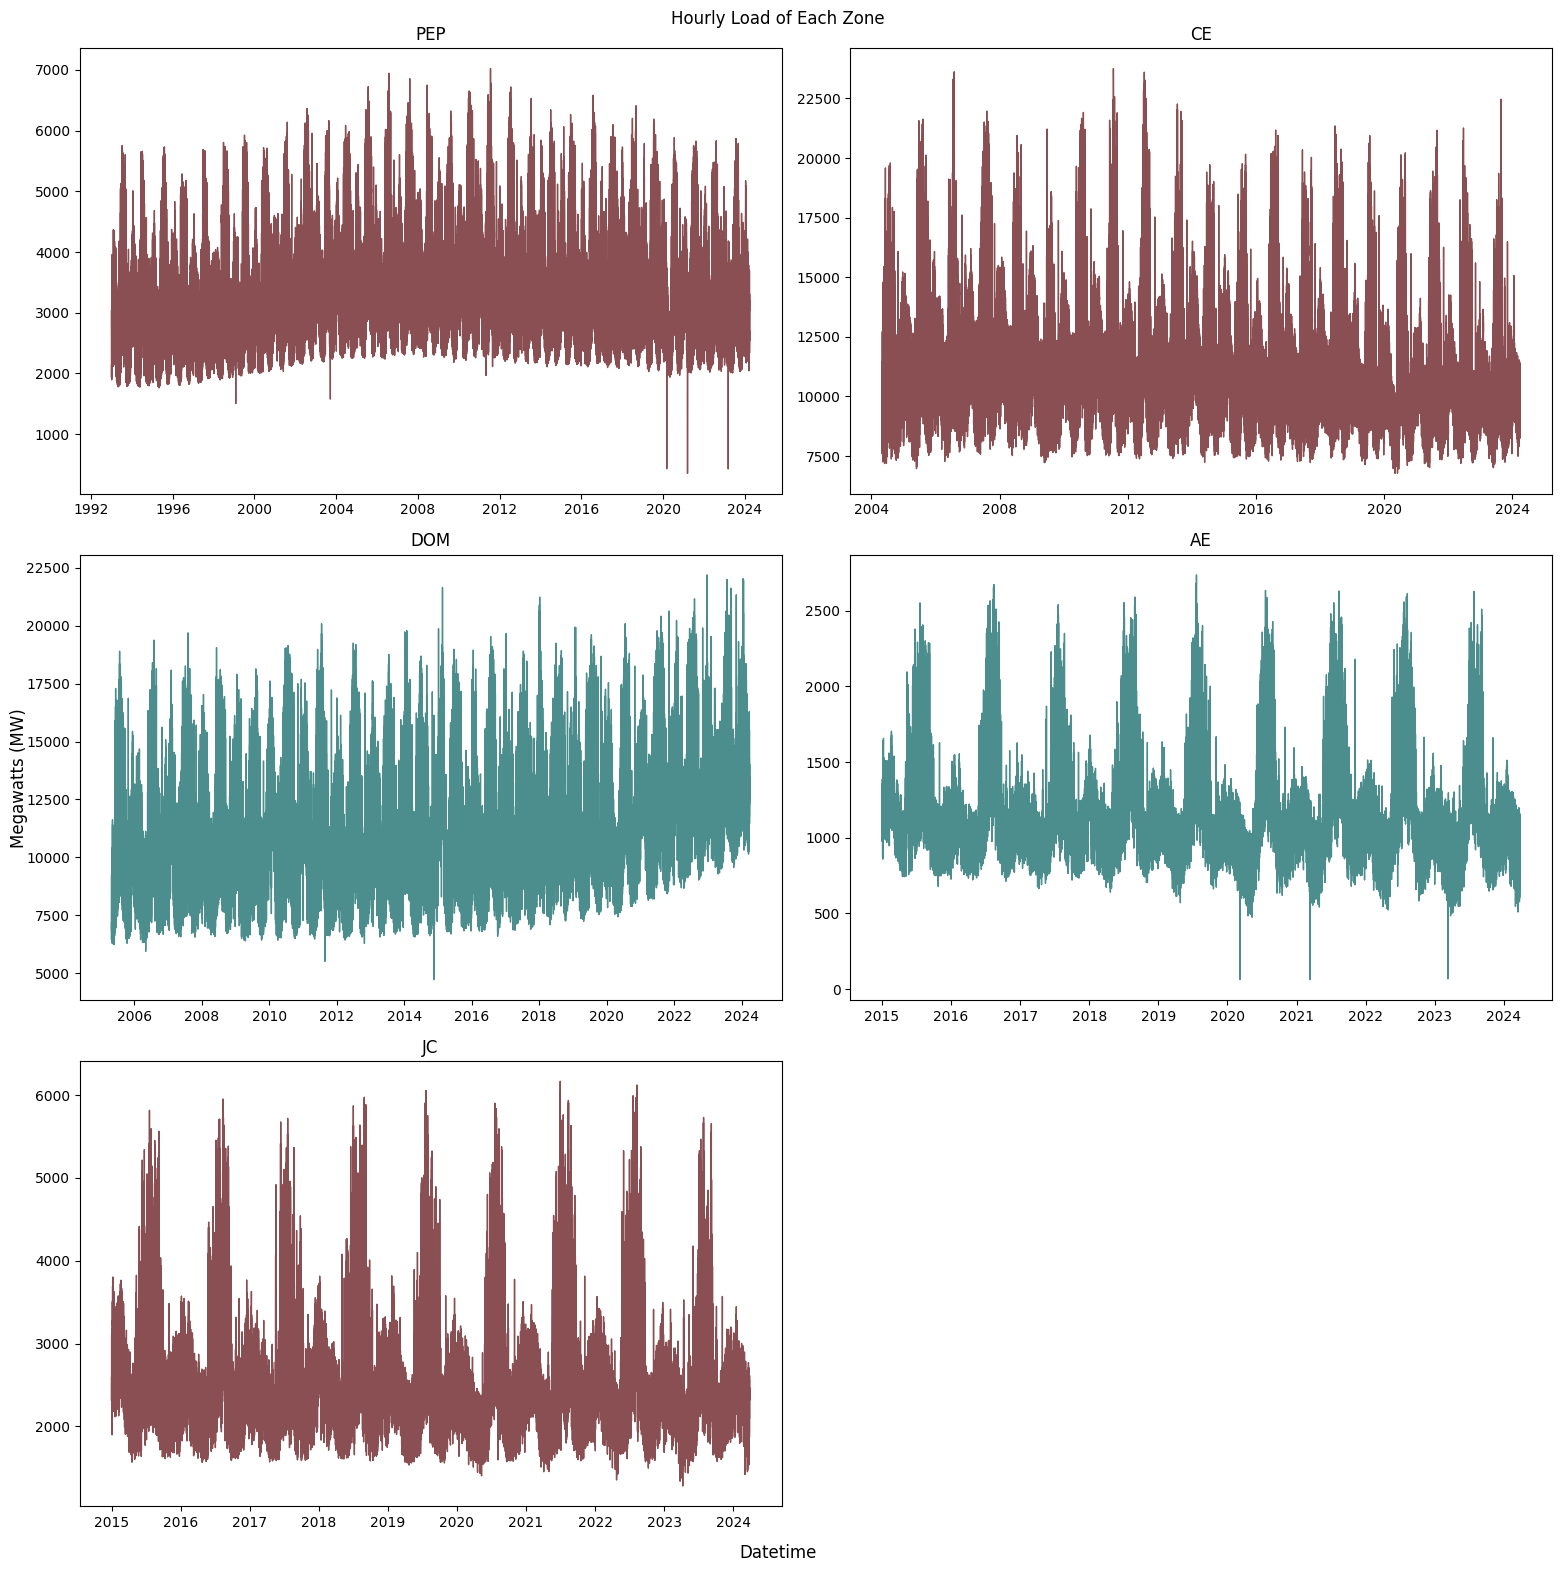

In [69]:
load_zone_plot(load_zone_df)

In [163]:
def plot_daterange(date_min, date_max, zone_select):
    """Plots MW vs Date in given date range and zone. Interval starts and ends at midnight.
    Note: Some of the text positions break down with larger ranges.
    Ideal range is two-weeks.

    Parameters:
        date_min (string): Date of beginning of interval (inclusive).
        date_max (string): Date of end of interval (inclusive).
        zone_select (string): Zone from load_zone_df to plot.
    
    Returns:
        None. Prints plot to output."""
    
    date_min = pd.to_datetime(f'{date_min} 00:00:00')
    date_max = pd.to_datetime(f'{date_max} 00:00:00')
    date_range = (date_max - date_min).days
    weather_temp = weather_df.loc[(weather_df['Date'].between(date_min, date_max, inclusive='both')) & 
                                (weather_df['zone'] == zone_select)].reset_index(drop = True)

    plt.subplots(figsize = (14, 8))
    sns.lineplot(load_zone_df.loc[(load_zone_df['datetime_beginning_ept'].between(date_min, date_max, inclusive='both')) & 
                                    (load_zone_df['zone'] == zone_select)], 
                    x = 'datetime_beginning_ept', 
                    y = 'mw',  
                    alpha = 0.7, lw = 1, marker = 'o')

    # Iterates through each day in range.
    for i in range(date_range + 1):
        # Day separating line.
        plt.axvline(date_min + pd.Timedelta(days = i), color = 'purple', ls = '--')
        if i > date_range-1:
            continue
        # Day of the week.
        plt.text(x = date_min + pd.Timedelta(days = i) + pd.Timedelta(hours = 10),
                    y = (plt.ylim()[0] + plt.ylim()[1]) / 2,
                    s = f'{(date_min + pd.Timedelta(days = i)).day_name()}',
                    rotation = 'vertical',
                    alpha = 0.75)
        # Temperatures.
        # High
        plt.text(x = date_min + pd.Timedelta(days = i) + pd.Timedelta(hours = 6),
                    y = ((plt.ylim()[0] + plt.ylim()[1]) / 2) + ((plt.ylim()[0] + plt.ylim()[1]) / 8),
                    s = f"Hi:{weather_temp['MaxTemperature'].iloc[i]}\N{DEGREE SIGN}",
                    rotation = 'horizontal',
                    alpha = 0.75)
        # Low
        plt.text(x = date_min + pd.Timedelta(days = i) + pd.Timedelta(hours = 6),
                    y = ((plt.ylim()[0] + plt.ylim()[1]) / 2) - ((plt.ylim()[0] + plt.ylim()[1]) / 8),
                    s = f"Lo:{weather_temp['MinTemperature'].iloc[i]}\N{DEGREE SIGN}",
                    rotation = 'horizontal',
                    alpha = 0.75)
    return None

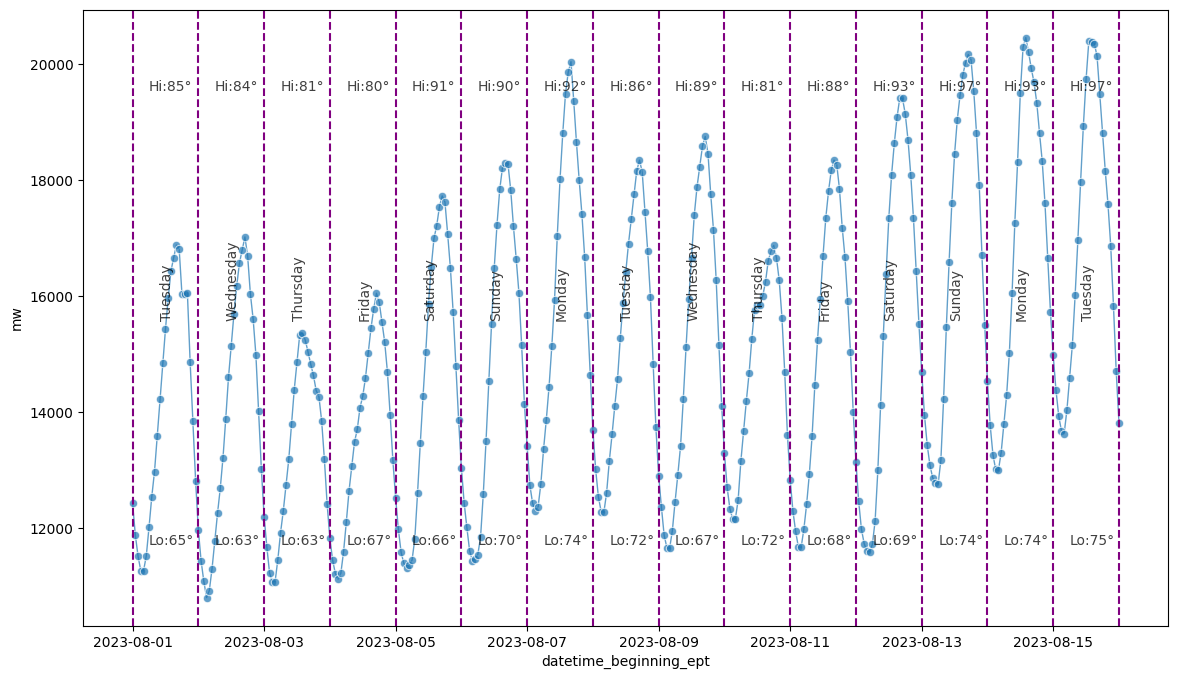

In [166]:
plot_daterange('8/01/2023', '8/16/2023', 'DOM')

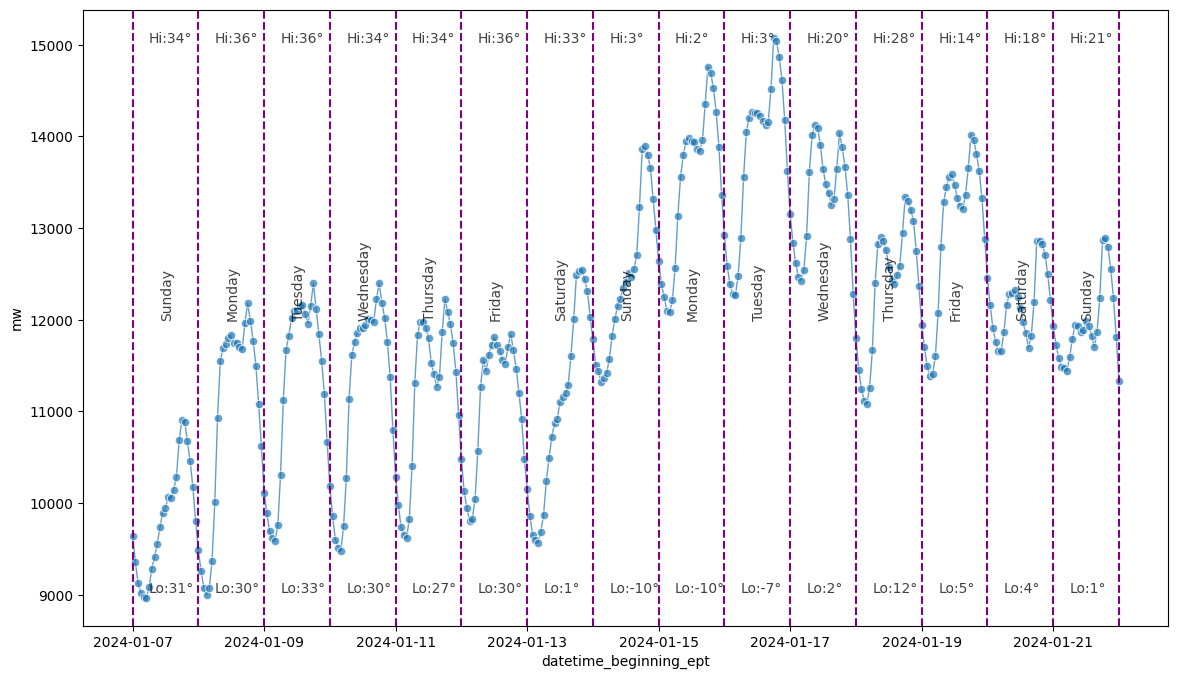

In [159]:
plot_daterange('01/07/2024', '01/22/2024', 'CE')

In [72]:
gen_fuel_df = gen_df[['datetime_beginning_ept', 'fuel_type', 'mw']].groupby(['datetime_beginning_ept', 'fuel_type'], as_index = False).sum()

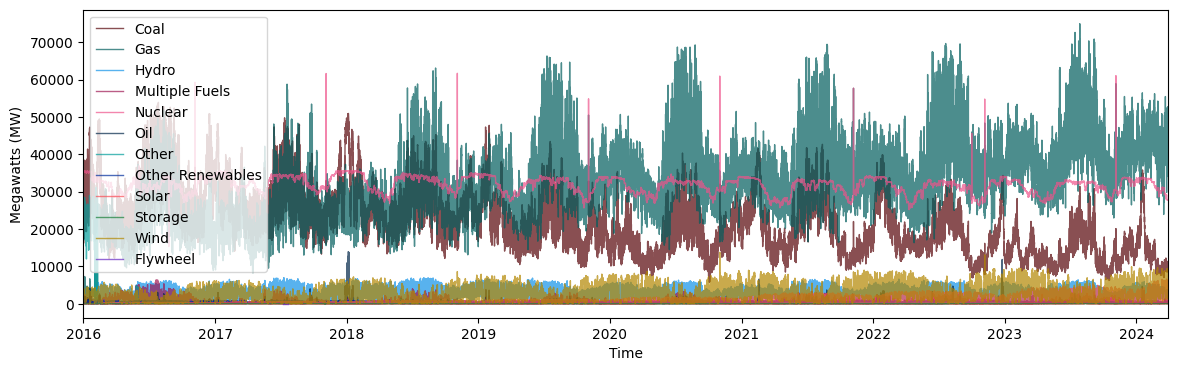

In [73]:
palette = ['#570408', '#005d5d', '#1192e8', '#9f1853', '#ee538b', '#012749', '#009d9a', '#002d9c', '#fa4d56', '#198038', '#b28600', '#6929c4']

ax, fig = plt.subplots(figsize = (14, 4))
ax = sns.lineplot(gen_fuel_df, x = 'datetime_beginning_ept', y = 'mw',  hue = 'fuel_type', alpha = 0.7, lw = 1, palette = sns.color_palette(palette, 12))
ax.margins(x = 0)
ax.set_xlabel('Time')
ax.set_ylabel('Megawatts (MW)')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles = handles, labels = labels)
plt.legend(loc = 'upper left')
plt.show()

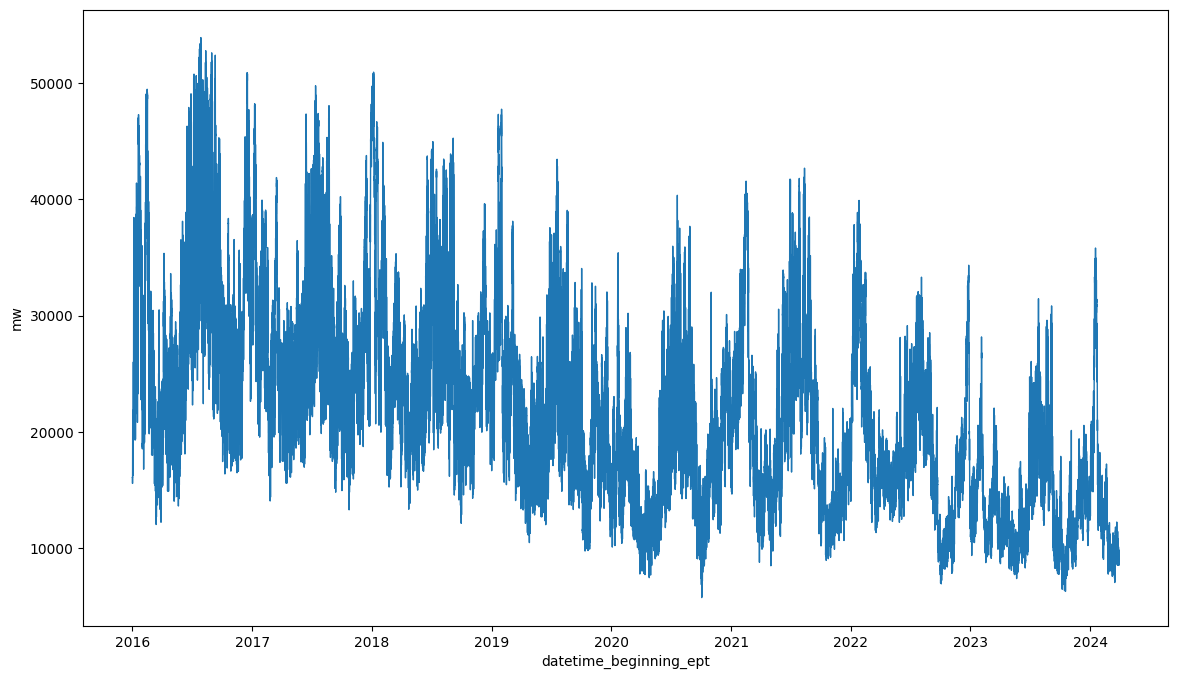

In [74]:
ax, fig = plt.subplots(figsize = (14, 8))
ax = sns.lineplot(gen_fuel_df.loc[gen_fuel_df['fuel_type'] == 'Coal'], x = 'datetime_beginning_ept', y = 'mw', lw = 1)

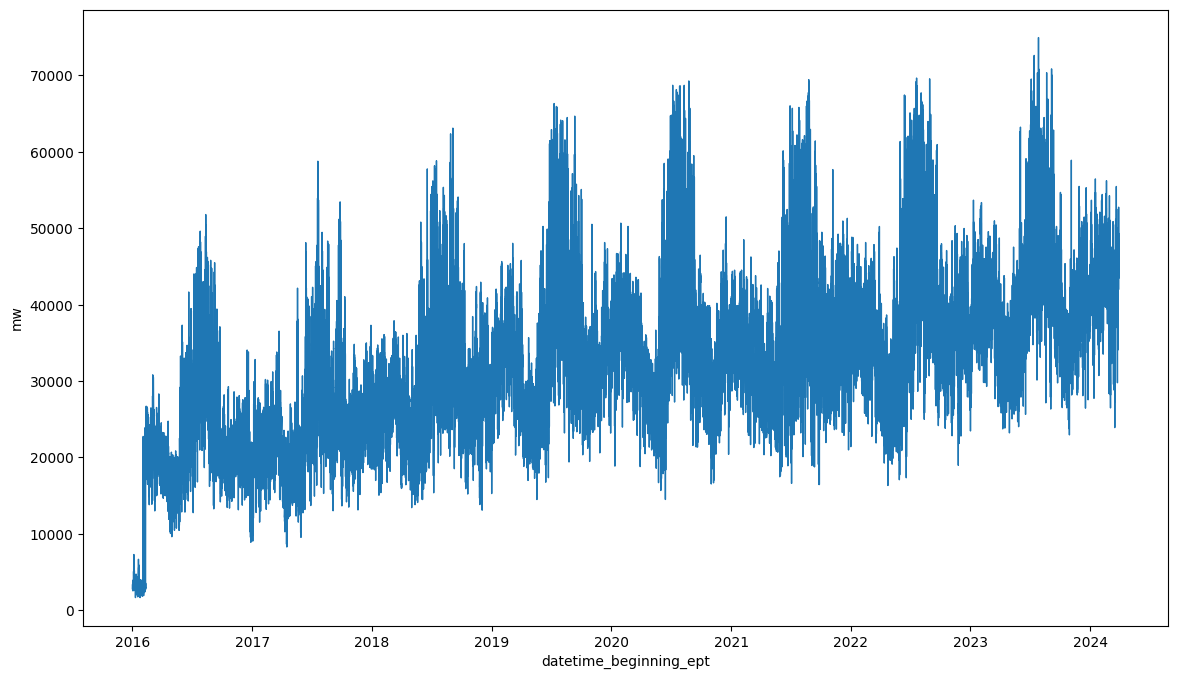

In [75]:
ax, fig = plt.subplots(figsize = (14, 8))
ax = sns.lineplot(gen_fuel_df.loc[gen_fuel_df['fuel_type'] == 'Gas'], x = 'datetime_beginning_ept', y = 'mw', lw = 1)

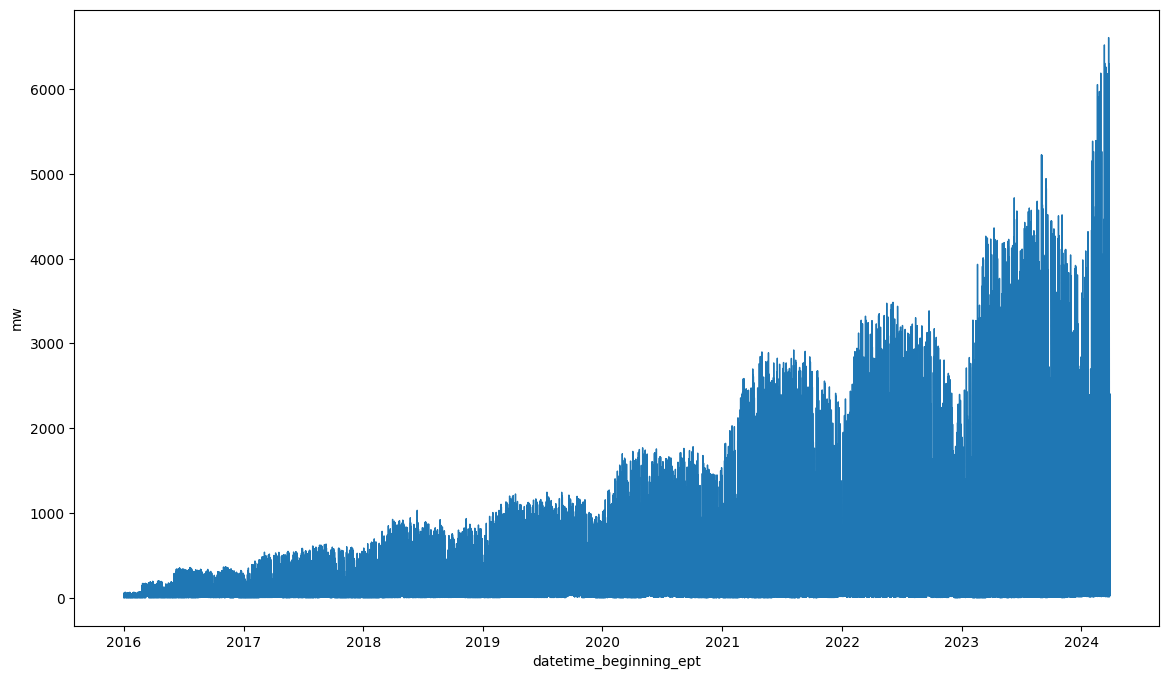

In [76]:
ax, fig = plt.subplots(figsize = (14, 8))
ax = sns.lineplot(gen_fuel_df.loc[gen_fuel_df['fuel_type'] == 'Solar'], x = 'datetime_beginning_ept', y = 'mw', lw = 1)

In [77]:
print(gen_df['datetime_beginning_ept'].min())
print(gen_df['datetime_beginning_ept'].max())
print(load_df['datetime_beginning_ept'].min())
print(load_df['datetime_beginning_ept'].max())

2016-01-01 00:00:00
2024-03-28 23:00:00
1993-01-01 00:00:00
2024-03-27 23:00:00


## Seeking the Prophet

---

Just temporarily building a model from Meta's Prophet to use in a few visualizations.

Feelin' cute, might delete later.

In [78]:
df = pd.DataFrame({'ds' : gen_fuel_df.loc[gen_fuel_df['fuel_type'] == 'Gas']['datetime_beginning_ept'],
                   'y' : gen_fuel_df.loc[gen_fuel_df['fuel_type'] == 'Gas']['mw']})
m = Prophet()
m.fit(df)

12:10:18 - cmdstanpy - INFO - Chain [1] start processing
12:10:44 - cmdstanpy - INFO - Chain [1] done processing


,ds
72811,2026-03-24 23:00:00
72812,2026-03-25 23:00:00
72813,2026-03-26 23:00:00
72814,2026-03-27 23:00:00
72815,2026-03-28 23:00:00


,ds,yhat,yhat_lower,yhat_upper
72811,2026-03-24 23:00:00,43858.316800,-12919.560185,95497.808175
72812,2026-03-25 23:00:00,43882.657178,-13379.842564,95032.345679
72813,2026-03-26 23:00:00,43271.392986,-14814.747063,93544.243538
72814,2026-03-27 23:00:00,41712.455949,-14587.601761,93757.377971
72815,2026-03-28 23:00:00,38005.122236,-18863.259299,90172.011835


/opt/homebrew/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/homebrew/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


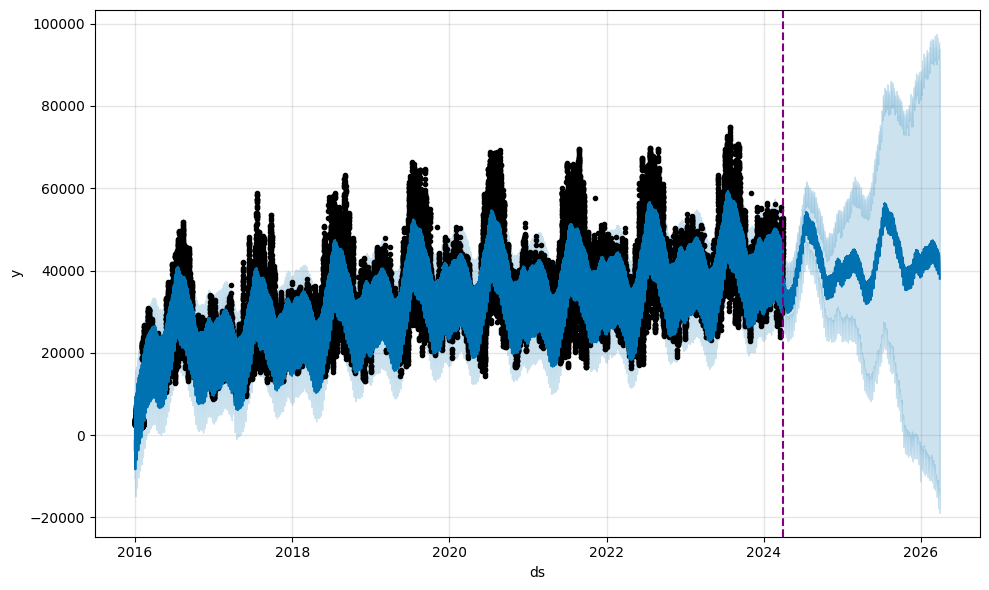

In [79]:
future = m.make_future_dataframe(periods=365*2)
display(future.tail())
forecast = m.predict(future)
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
fig1 = m.plot(forecast)
ax = fig1.gca()
plt.axvline(max(df['ds']), color = 'purple', ls = '--')

In [80]:
# Sourced from the prophet repository and repurposed to include:
# - Delineate observed data and forecasted data (dashed line)
# - Separate observed data and forecasted data for different visuals
# - Color changes
# - Zoom into the last few years to better visualize forecast (currently hardcoded)

def prophetplot(m, fcst, ax=None, uncertainty=True, plot_cap=True, xlabel='Time', ylabel='Megawatts (MW)',
    figsize=(10, 6), include_legend=False):
    """Plot the Prophet forecast.

    Parameters
    ----------
    m: Prophet model.
    fcst: pd.DataFrame output of m.predict.
    ax: Optional matplotlib axes on which to plot.
    uncertainty: Optional boolean to plot uncertainty intervals, which will
        only be done if m.uncertainty_samples > 0.
    plot_cap: Optional boolean indicating if the capacity should be shown
        in the figure, if available.
    xlabel: Optional label name on X-axis
    ylabel: Optional label name on Y-axis
    figsize: Optional tuple width, height in inches.
    include_legend: Optional boolean to add legend to the plot.
    Returns
    -------
    A matplotlib figure.
    """
    user_provided_ax = False if ax is None else True
    if ax is None:
        fig = plt.figure(facecolor='w', figsize=figsize)
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
    fcst_t = fcst['ds']#.dt.to_pydatetime()

    # Initialize the observation and forecast data variables
    # Finds and separates the two sets by using the max date in (observed) input data.
    obs_t = fcst_t.loc[fcst_t < max(df['ds'])]
    obs_yhat = fcst['yhat'].iloc[ : fcst['ds'].loc[fcst['ds'] <= max(df['ds'])].index[-1]]
    obs_lower = fcst['yhat_lower'].iloc[ : fcst['ds'].loc[fcst['ds'] <= max(df['ds'])].index[-1]]
    obs_upper = fcst['yhat_upper'].iloc[ : fcst['ds'].loc[fcst['ds'] <= max(df['ds'])].index[-1]]
    fc_t = fcst_t.loc[fcst_t >= max(df['ds'])]
    fc_yhat = fcst['yhat'].iloc[fcst['ds'].loc[fcst['ds'] >= max(df['ds'])].index[0]:]
    fc_lower = fcst['yhat_lower'].iloc[fcst['ds'].loc[fcst['ds'] >= max(df['ds'])].index[0]:]
    fc_upper = fcst['yhat_upper'].iloc[fcst['ds'].loc[fcst['ds'] >= max(df['ds'])].index[0]:]

    ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], '.', c = '#012749', markersize = 1, alpha = 0.9,
            label='Observed data points')
    ax.plot(obs_t, obs_yhat, ls='-', c='#005d5d', label='Forecast', lw = 0.75, alpha = 0.9)
    ax.plot(fc_t, fc_yhat, ls='-', c='#382238', label='Predict', lw = 0.75, alpha = 1)
    if 'cap' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['cap'], ls='--', c='k', label='Maximum capacity')
    if m.logistic_floor and 'floor' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['floor'], ls='--', c='k', label='Minimum capacity')
    if uncertainty and m.uncertainty_samples:
        ax.fill_between(obs_t, obs_lower, obs_upper,
                        color='#009d9a', alpha=0.4, label='Uncertainty interval')
        ax.fill_between(fc_t, fc_lower, fc_upper,
                        color='#753f75', alpha=0.4, label='Uncertainty interval')
    # Specify formatting to workaround matplotlib issue #12925
    locator = AutoDateLocator(interval_multiples=False)
    formatter = AutoDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.grid(True, which='major', c='gray', ls='-', lw=0.75, alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Zoom in x-axis closer to prediction.
    ax.set_xlim(pd.to_datetime(['2020-01-01 00:00:00', '2026-01-01 00:00:00']))
    ax.set_ylim(0, 90000)

    # Prediction divider line.
    plt.axvline(max(df['ds']), color = 'black', ls = '--', lw = 1.2)

    # Linear trend line to calculate yearly increase.
    obs_poly_fn = np.poly1d(np.polyfit(range(len(obs_t)), obs_yhat, 1))
    plt.plot(obs_t, obs_poly_fn(range(len(obs_t))), c = '#913529')

    fc_poly_fn = np.poly1d(np.polyfit(range(len(fc_t)), fc_yhat, 1))
    plt.plot(fc_t, fc_poly_fn(range(len(fc_t))), c = '#252f9c')

    if include_legend:
        ax.legend()
        plt.legend(loc = 'upper left')
    if not user_provided_ax:
        fig.tight_layout()
    return fig

/var/folders/m8/939h_p3x6fq4_c0w_pfktz840000gn/T/ipykernel_46884/1404529793.py:47: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], '.', c = '#012749', markersize = 1, alpha = 0.9,


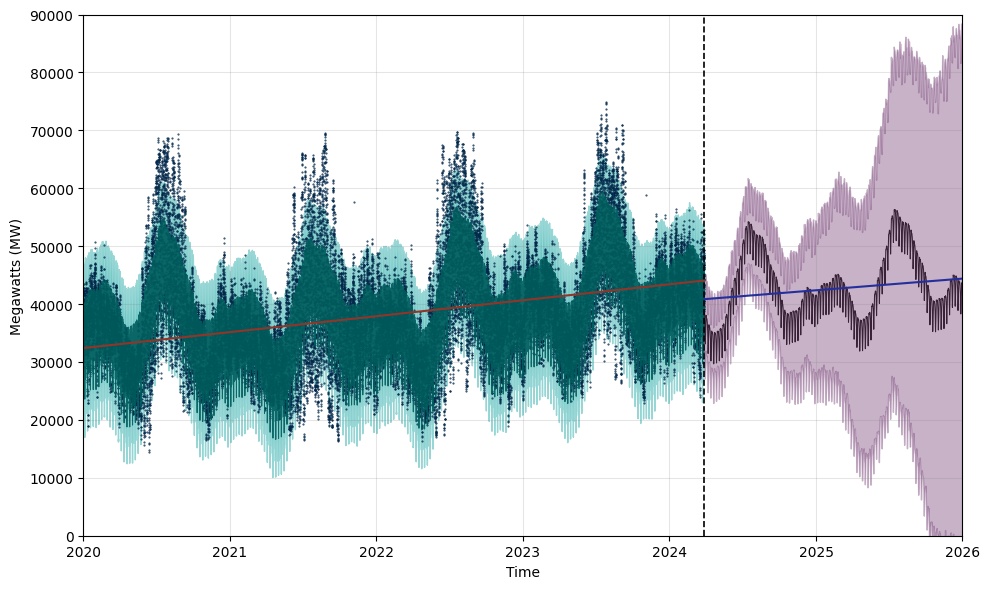

In [81]:
prophetplot(m, forecast)
plt.show()